In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

In [2]:
# Carregar dados do CPU
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


In [3]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [4]:
df1 = workload['cpu']
df1.values

array([17., 24., 16., ..., 26., 23., 21.])

In [5]:
#create numpy.ndarray
df1 = workload['cpu']
df_arr= df1.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [6]:
train_size = int(len(df1) * 0.75)
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 60
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [7]:
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse'])
    return model

In [8]:
model=model_lstm(look_back)
history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], verbose=1, shuffle=False)

Epoch 1/100
286/286 [==============================] - 1s 2ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 2/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 3/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 4/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 5/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 6/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 7/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 8/100
286/286 [==============================] - 0s 1ms/step - 

286/286 [==============================] - 0s 1ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 63/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 64/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 65/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 66/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 67/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 68/100
286/286 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 69/100
286/286 [==============================] - 0s 1ms/step - loss:

In [9]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train Root Mean Squared Error(RMSE): 7.41; Train Mean Absolute Error(MAE) : 5.39 
Test Root Mean Squared Error(RMSE): 7.78; Test Mean Absolute Error(MAE) : 5.82 


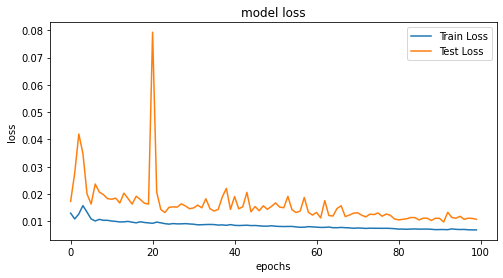

In [10]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)[:,0]
trainY = scaler.inverse_transform(trainY)[:,0]
test_predict = scaler.inverse_transform(test_predict)[:,0]
testY = scaler.inverse_transform(testY)[:,0]
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(trainY, train_predict)),(mean_absolute_error(trainY, train_predict))))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f '% (np.sqrt(mean_squared_error(testY, test_predict)),(mean_absolute_error(testY, test_predict))))
model_loss(history)

In [11]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')

<AxesSubplot:>

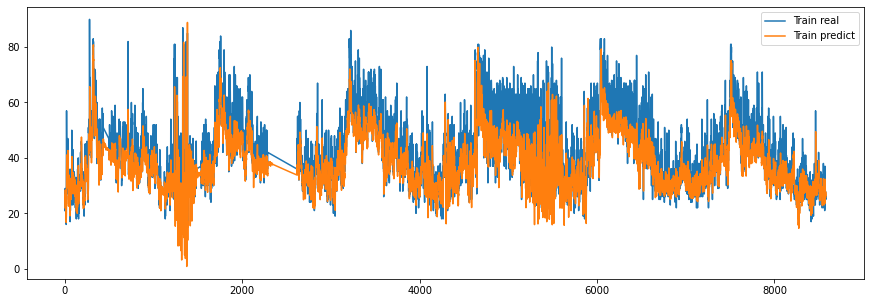

In [12]:
train_results = pd.DataFrame({'Train real':trainY, 'Train predict': train_predict})
train_results.plot(figsize=(15,5))

In [13]:
# validate real with predict
validate(trainY, train_predict)

mean_squared_error: 54.92297081743487
root_mean_squared_error: 7.411003361045984
Determination coeficient: 0.6415606476320215
explained_variance_score: 0.7305598006685412
max_error: 52.00504493713379
mean_absolute_error: 5.389010302931667


<AxesSubplot:>

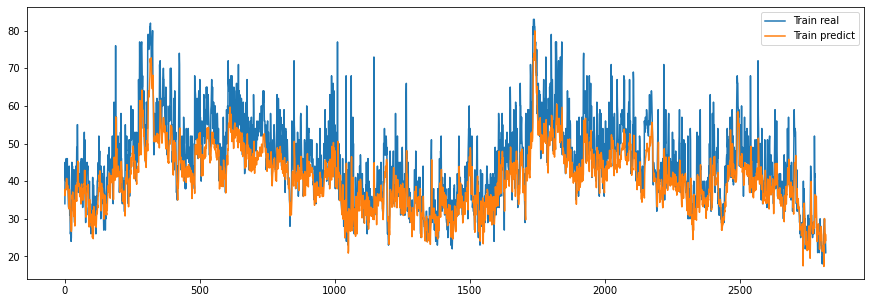

In [14]:
test_results = pd.DataFrame({'Train real':testY, 'Train predict': test_predict})
test_results.plot(figsize=(15,5))

In [15]:
# validate predict with real
validate(testY, test_predict)

mean_squared_error: 60.45671245286242
root_mean_squared_error: 7.7753914662132875
Determination coeficient: 0.5091424112648162
explained_variance_score: 0.6669300349872513
max_error: 43.22128486633301
mean_absolute_error: 5.821563690943074
